# Example notebook: RotatingFrame

In [1]:
using IonSim
using QuantumOptics: timeevolution, stochastic, Basis
import PyPlot

# On-resonant Rabi flops

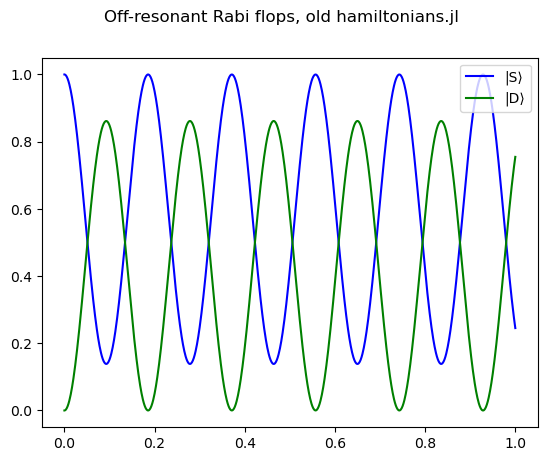

In [3]:
"""
The core reason for the inclusion of rotating frames within IonSim is because the differential equation solver
is unable to find convergent solutions for rapidly time-varying hamiltonians. When constructed in the lab frame,
the hamiltonian for the case of a two-level atom being driven harmonically via its dipole interaction has the
form

    H = H₀ + H₁,

    H₁ = -d⃗⋅E⃗

and if the dipole matrix element is real we can write (for levels |g⟩ and |e⟩)

    H₁ = -dE₀σₓ(e^(iνt)+e^(-iνt)).

This has rapidly time-varying terms - the optical frequency ν is generally THz scale. We might be saved, 
however, by the fact that we can make a unitary transformation U which depends on time such that our effective 
Hamiltonian is given by

    H̃ = UHU† - iUU̇†.

This is known as "going into a rotating frame". H̃ has terms with both slow (or sometimes zero) time 
dependence, and terms with comparably fast time dependence. The fast-oscillating terms are generally then 
thrown away as they quickly average to zero on the relevant timescales in what is known as the "rotating wave 
approximation." 

One could define U to be the diagonal matrix whose entries are 

    U[j,j] = e^(-iEⱼt/ħ)

where Eⱼ is the energy of the jᵗʰ eigenstate of the bare Hamiltonian H₀. This is known as the interaction
picture, and it is of much use for simulating nearly-resonantly-driven processes. In this picture, for a 
two-level system, the slow-varying terms in the hamiltonian oscillate at the detuning of the drive frequency 
from the transition frequency, Δ. Thus if Δ is small, the computational solver can find convergent solutions
in this rotating frame. What is important to keep in mind is that the interaction picture is itself a
rotating frame, and that it does not entirely eliminate time dependent terms even for a two-level system unless
the drive is perfectly resonant with the transition.

Here, we will explore how to get useful, simulable Hamiltonians in IonSim, both when the process of interest
is driven near resonance, and when it is not.

Let's define a two-level atom with a two-level vibrational mode, for a 4-dimensional Hilbert space.
"""
ca = Ca40([("S1/2", -1/2, "S"), ("D5/2", -1/2, "D")])
laser = Laser()
chain = LinearChain(
        ions=[ca],
        comfrequencies=(x=3e6,y=3e6,z=1e6), 
        selectedmodes=(;z=[1])
    )

b = 4e-4

chamber = Chamber(iontrap=chain, B=b, Bhat=ẑ, δB=0, lasers=[laser])

#Set the vibrational Hilbert space to {0,1}.
modecutoff!(modes(chamber)[1],1)

#Detune the drive laser by a relatively small amount, say 2 MHz.
wavelength_from_transition!(laser, ca, ("S", "D"), chamber)
detuning!(laser,2e6)
polarization!(laser, (x̂ - ẑ)/√2)
wavevector!(laser, (x̂ + ẑ)/√2)
intensity_from_pitime!(laser, 1e-7, ca, ("S", "D"), chamber);  # Sets pi_time to 2 μs


"""
Let's look at the arguments for hamiltonian():

hamiltonian(
    chamber::Chamber;
    rotatingframe::Union{RotatingFrame,String}="interaction",
    timescale::Real=1,
    lamb_dicke_order::Union{Vector{Int}, Int}=1,
    rwa_cutoff::Real=Inf,
    displacement::String="truncated",
    time_dependent_eta::Bool=false
)

Note that the only argument which must be supplied is chamber. The others all have default values, and the
default value of the rotatingframe argument is "interaction", a string. If this string or no argument is
supplied for the rotating frame, IonSim will automatically assume that you want to work in the interaction
picture. Let's see this in action:
"""

h = hamiltonian(chamber, timescale=1e-6, rwa_cutoff=5e6, lamb_dicke_order=1)
S0 = ca["S"] ⊗ modes(chamber)[1][1]
τ = 1
steps = 1000
tspan = 0:τ/steps:τ
ρi = dm(S0)
J = one(ρi)
γ = 1

_, ρt = timeevolution.master_dynamic(tspan, ρi, (t, ρ) -> (h(t, ρ), [J], [J], [γ]))

slist = real(expect(ionprojector(chamber,"S"),ρt))
dlist = real(expect(ionprojector(chamber,"D"),ρt))

fig, (ax1) = PyPlot.subplots(1)
fig.suptitle("Off-resonant Rabi flops, old hamiltonians.jl")
ax1.plot(tspan,slist,color="blue",label="|S⟩")
ax1.plot(tspan,dlist,color="green",label="|D⟩")
ax1.legend(loc=1);

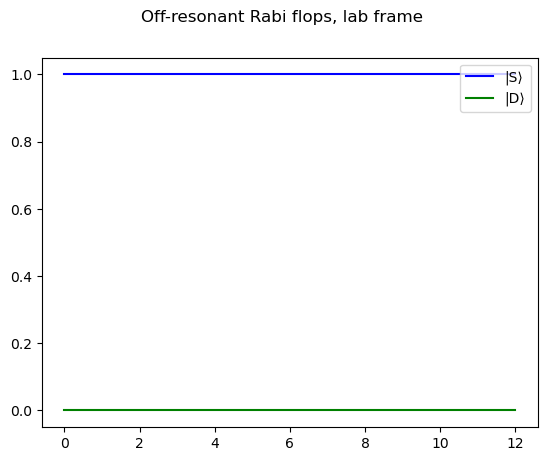

In [45]:
"""
And we see the dynamics we expect to see. Fiddling with the laser detuning will change the contrast and the 
frequency of the oscillations, and we should see perfect contrast for Δ = 0.

But how do we know that there is anything special about the interaction picture? Let's see what happens
when we construct a dummy RotatingFrame object which does nothing, and feed that to the hamiltonian() function.

To construct a rotating frame, we need to define operators (using IonSim's convenience functions makes our lives
easier here). A rotating frame is constructed in general via

    U = Πⱼe^(-iϕⱼDⱼt)

where j runs from 1 to the number of operators used to specify the frame, and Dⱼ is a diagonal operator.
ϕⱼ is specified by the user - in the example below, ϕ₁ is set to 0 so that U = 1 and we are not making any
rotating frame. This sort of "hack" is needed to see the lab frame hamiltonian because it is useless for any
computational purpose and IonSim does not have any motivation to keep track of it. However, it IS important
to take away from this that IonSim's RotatingFrame should be built with respect to the lab frame (not the
interaction picture), consistent with the idea that the interaction picture is just a specific choice of
rotating frame.
"""

P₁₁ = IonSim.ionprojector(chamber,1)
P₂₂ = IonSim.ionprojector(chamber,2)
num = IonSim.number(chamber,1)
rf_lab = RotatingFrame(chamber,[(P₁₁,0.0)])
h1_lab = hamiltonian(chamber, rotatingframe=rf_lab, timescale=1e-6, rwa_cutoff=5e6, lamb_dicke_order=1)
_, ρt = timeevolution.master_dynamic(tspan, ρi, (t, ρ) -> (h1_lab(t, ρ), [J], [J], [γ]))

slist = real(expect(ionprojector(chamber,"S"),ρt))
dlist = real(expect(ionprojector(chamber,"D"),ρt))

fig, (ax1) = PyPlot.subplots(1)
fig.suptitle("Off-resonant Rabi flops, lab frame")
ax1.plot(tspan,slist,color="blue",label="|S⟩")
ax1.plot(tspan,dlist,color="green",label="|D⟩")
ax1.legend(loc=1);

In [46]:
"""
We see absolutely nothing happening! That is because the rwa_cutoff parameter tells the solver what frequencies
are too fast to bother trying to calculate - any terms in the hamiltonian oscillating faster than this are
set to zero, assumed to time average to zero over the timescale of interest. In the laboratory frame, the
transition terms oscillate at the laser frequency, which is far greater than 5 MHz, so we see no dynamics.

But what if we just provide no rwa_cutoff? The default argument is ∞, so here goes nothing:
"""

h1_lab = hamiltonian(chamber, rotatingframe=rf_lab, timescale=1e-6, lamb_dicke_order=1)
_, ρt = timeevolution.master_dynamic(tspan, ρi, (t, ρ) -> (h1_lab(t, ρ), [J], [J], [γ]))

slist = real(expect(ionprojector(chamber,"S"),ρt))
dlist = real(expect(ionprojector(chamber,"D"),ρt))

fig, (ax1) = PyPlot.subplots(1)
fig.suptitle("Off-resonant Rabi flops, lab frame")
ax1.plot(tspan,slist,color="blue",label="|S⟩")
ax1.plot(tspan,dlist,color="green",label="|D⟩")
ax1.legend(loc=1);

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase /Users/justin/.julia/packages/SciMLBase/VdcHg/src/integrator_interface.jl:575


LoadError: PyError ($(Expr(:escape, :(ccall(#= /Users/justin/.julia/packages/PyCall/7a7w0/src/pyfncall.jl:43 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'ValueError'>
ValueError('x and y must have same first dimension, but have shapes (1001,) and (1,)')
  File "/Users/justin/.julia/conda/3/lib/python3.9/site-packages/matplotlib/axes/_axes.py", line 1632, in plot
    lines = [*self._get_lines(*args, data=data, **kwargs)]
  File "/Users/justin/.julia/conda/3/lib/python3.9/site-packages/matplotlib/axes/_base.py", line 312, in __call__
    yield from self._plot_args(this, kwargs)
  File "/Users/justin/.julia/conda/3/lib/python3.9/site-packages/matplotlib/axes/_base.py", line 498, in _plot_args
    raise ValueError(f"x and y must have same first dimension, but "


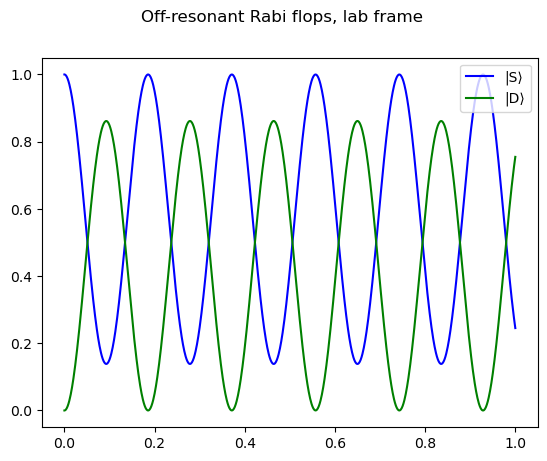

In [11]:
"""
As you probably will see, the solver fails to find a solution and throws an error in the face of such fast 
oscillations. The interaction picture is IonSim's fastest and most convenient way to simulate near-resonant
dynamics.

Of course, we could just manually construct the interaction picture as well.
"""
rf_int = RotatingFrame(chamber,[(P₁₁,energy(ca,"S",B=b)),(P₂₂,energy(ca,"D",B=b)),(num,1e6)])
h1_int = hamiltonian(chamber, rotatingframe=rf_int, timescale=1e-6, rwa_cutoff=5e6, lamb_dicke_order=1)
_, ρt = timeevolution.master_dynamic(tspan, ρi, (t, ρ) -> (h1_int(t, ρ), [J], [J], [γ]));

slist = real(expect(ionprojector(chamber,"S"),ρt))
dlist = real(expect(ionprojector(chamber,"D"),ρt))

fig, (ax1) = PyPlot.subplots(1)
fig.suptitle("Off-resonant Rabi flops, lab frame")
ax1.plot(tspan,slist,color="blue",label="|S⟩")
ax1.plot(tspan,dlist,color="green",label="|D⟩")
ax1.legend(loc=1);

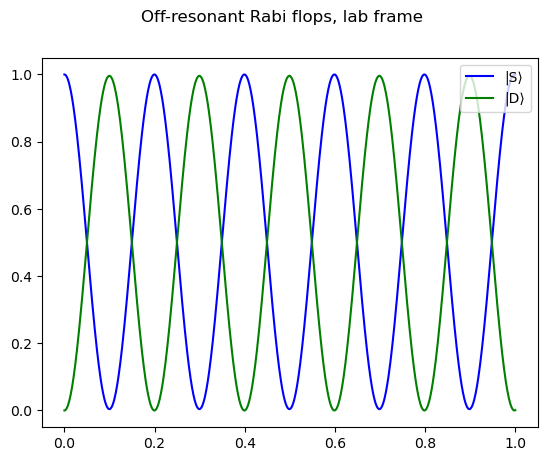

In [36]:
"""
To drive our point home, let's look at one more on-resonant example with another rotating frame. This time,
we will choose

    U = e^(-iνP₂₂t)

where we spin the excited state |2⟩ ≡ |D⟩ "backwards" at the laser frequency. This transformation is distinct
from the interaction picture, and for a two-level system is the transformation that totally eliminates time 
dependence (hence the name rf_perfect below). We are so confident in this fact that we will set the rwa_cutoff
argument to 0, and still see the dynamics! This doesn't work for the interaction picture, unless the detuning
is zero. Try it!
"""

c = 299792458
ν = c/wavelength(laser) + detuning(laser)
rf_perfect = RotatingFrame(chamber,[(P₂₂,ν)])
h1_perfect = hamiltonian(chamber, rotatingframe=rf_perfect, timescale=1e-6, rwa_cutoff=0, lamb_dicke_order=1)
_, ρt = timeevolution.master_dynamic(tspan, ρi, (t, ρ) -> (h1_perfect(t, ρ), [J], [J], [γ]));

slist = real(expect(ionprojector(chamber,"S"),ρt))
dlist = real(expect(ionprojector(chamber,"D"),ρt))

fig, (ax1) = PyPlot.subplots(1)
fig.suptitle("Off-resonant Rabi flops, lab frame")
ax1.plot(tspan,slist,color="blue",label="|S⟩")
ax1.plot(tspan,dlist,color="green",label="|D⟩")
ax1.legend(loc=1);

# Off-resonant dynamics: Raman transitions

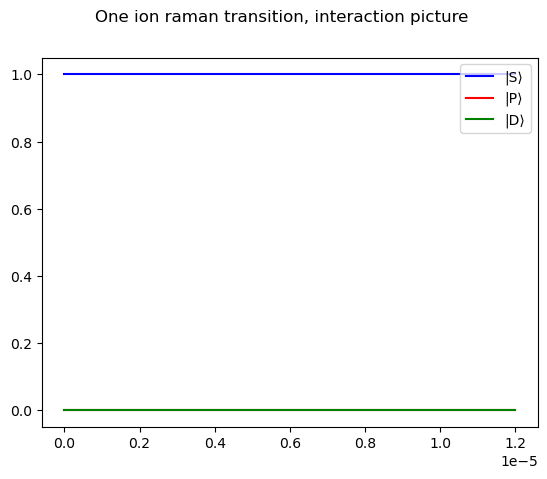

In [37]:
"""
Now we, consider a three-level (Λ) system comprised of two low-lying states |S⟩ and |D⟩, and a higher-energy 
state |P⟩. |S⟩ ↔ |P⟩ and |P⟩ ↔ |D⟩ are dipole-allowed transitions, but |S⟩ ↔ |D⟩ is not. We may couple the two
low-lying states via two lasers, each of which couples one of the dipole-allowed transitions with a large
detuning. Each laser is far-detuned from the transition it drives, so that the population in the |P⟩ state is
nearly 0 for all time. We call this 'adiabatically eliminating' the |P⟩ state. The end result is a Rabi
oscillation between the |S⟩ and |D⟩ levels, whose contrast and frequency depends on the two-photon detuning, 

    δ ≡ Δ₂ - Δ₁. 

This is known as a Raman process. The dynamics in the lab frame are at THz frequencies as usual, but in the 
interaction picture, they are often still at hundreds of MHz.
"""

ca = Ca40([("S1/2", -1/2, "S"), ("P3/2",-1/2, "P"),("D5/2", -1/2, "D")])

#one motional mode
#νr = 4e6
#νa = 1e6


#two lasers
#set laser wavelength and power
Δ = 2π*300e6 #Absolute laser detuning is large compared to Ω₁, Ω₂
δ = 0#10e3 #two-photon detuning
Ω₁ = 10e6
Ω₂ = 10e6
l1 = Laser()
l2 = Laser()

#configure trap
chain = LinearChain(
        ions=[ca],
        comfrequencies=(x=3e6,y=3e6,z=1e6), 
        selectedmodes=(;z=[1])
    )
b = 0
chamber = Chamber(iontrap=chain, B=b, Bhat=ẑ, δB=0, lasers=[l1,l2])
wavelength_from_transition!(l1, ca, ("S", "P"), chamber)
wavelength_from_transition!(l2, ca, ("D", "P"), chamber)
detuning!(l1,Δ)
detuning!(l2,Δ+δ)
polarization!(l1, (x̂ - ẑ)/√2)
polarization!(l2, (x̂ - ẑ)/√2)
wavevector!(l1, (x̂ + ẑ)/√2)
wavevector!(l2, (x̂ + ẑ)/√2)
intensity_from_pitime!(l1, 1/(2*Ω₁), ca, ("S", "P"), chamber)
intensity_from_pitime!(l2, 1/(2*Ω₂), ca, ("D", "P"), chamber)

axial = modes(chamber)[1]
modecutoff!(axial,1)

# set initial state |S⟩ ⊗ |0⟩
ψi = ca["S"]
ρi_ions = dm(ψi)
ρi_axial = dm(fockstate(axial, 0))
ρi = ρi_ions ⊗ ρi_axial

J = one(dm(ψi)) ⊗ one(axial)
γ = 1

Ω_eff = π*Ω₁*Ω₂/Δ
nflops = 2
τ = nflops/Ω_eff
steps = 1000
tspan = 0:τ/steps:τ

#Let's go to the interaction picture!

h_int = hamiltonian(chamber, rotatingframe="interaction", rwa_cutoff=5e6, lamb_dicke_order=2)
_, ρt = timeevolution.master_dynamic(tspan, ρi, (t, ρ) -> (h_int(t, ρ), [J], [J], [γ]))

slist = real(expect(ionprojector(chamber,"S"),ρt))
plist = real(expect(ionprojector(chamber,"P"),ρt))
dlist = real(expect(ionprojector(chamber,"D"),ρt))
nlist = real(expect(one(ρi_ions)⊗IonSim.number(axial),ρt))

fig, (ax1) = PyPlot.subplots(1)
fig.suptitle("One ion raman transition, interaction picture")
ax1.plot(tspan,slist,color="blue",label="|S⟩")
ax1.plot(tspan,plist,color="red",label="|P⟩")
ax1.plot(tspan,dlist,color="green",label="|D⟩")
ax1.legend(loc=1);

 25.773821 seconds (185.90 M allocations: 10.562 GiB, 4.64% gc time, 15.03% compilation time)


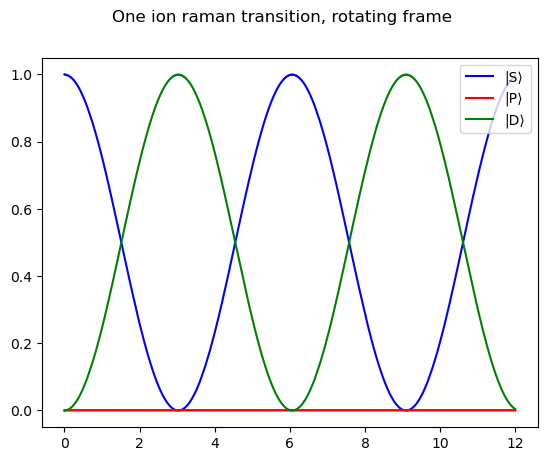

In [43]:
"""
Now, we won't see any dynamics, because the lasers are far detuned from the transitions, so the interaction
picture isn't good enough - we would need an rwa cutoff of 300 MHz to see these dynamics!
But the two-photon detuning is small (the lasers are each detuned by the same amount), so maybe there is
another frame we could intelligently choose...?

It turns out that there is a frame which we can choose to kill the time dependence. It can be worked out by
computing H̃ from the above, but with U having diagonal elements e^(-iϕⱼt), and computing which values of 
ϕⱼ cause all time-varying terms in H̃ to cancel, or otherwise oscillate at a sum of atomic and optical 
frequencies (to be thrown out in the RWA). This solution has a free parameter and so is not unique; the most 
symmetric solution is the one chosen here.
"""

P₁₁ = IonSim.ionprojector(chamber,1)
P₂₂ = IonSim.ionprojector(chamber,2)
P₃₃ = IonSim.ionprojector(chamber,3)
num = IonSim.number(chamber,1)

ν1 = (c/wavelength(l1) + detuning(l1))
ν2 = (c/wavelength(l2) + detuning(l2))

ϕ1 = (detuning(l2) - detuning(l1))/2
ϕ2 = ϕ1 + ν1
ϕ3 = ϕ2 - ν2

rf_raman = RotatingFrame(chamber,[(P₁₁,ϕ1),(P₂₂,ϕ2),(P₃₃,ϕ3),(num,1e6)])

Ω_eff = Ω₁*Ω₂/Δ
nflops = 2
τ = nflops/Ω_eff*1e6/π
steps = 1000
tspan = 0:τ/steps:τ
@time begin
    h_raman = hamiltonian(chamber, rotatingframe = rf_raman, timescale=1e-6, rwa_cutoff=0, lamb_dicke_order=0)
    _, ρt = timeevolution.master_dynamic(tspan, ρi, (t, ρ) -> (h_raman(t, ρ), [J], [J], [γ]))
end
slist = real(expect(ionprojector(chamber,"S"),ρt))
plist = real(expect(ionprojector(chamber,"P"),ρt))
dlist = real(expect(ionprojector(chamber,"D"),ρt))
nlist = real(expect(one(ρi_ions)⊗IonSim.number(axial),ρt))


fig, (ax1) = PyPlot.subplots(1)
fig.suptitle("One ion raman transition, rotating frame")
ax1.plot(tspan,slist,color="blue",label="|S⟩")
ax1.plot(tspan,plist,color="red",label="|P⟩")
ax1.plot(tspan,dlist,color="green",label="|D⟩")
ax1.legend(loc=1);

#= Look at the rwa cutoff, 0 once more! We have successfully chosen and implemented a rotating frame which
kills the time-dependence in the relevant terms.=#